In [360]:
import pandas as pd
from modules import Agent,Model
import numpy as np
import torch
import pickle
device = "cuda" if torch.cuda.is_available() else "cpu"
import matplotlib.pyplot as plt
import seaborn as sns
import os
from preprocessing import Feature_Extractor, data_preprocessing


Start Trading

In [361]:
symbol = "FPT"

In [362]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')

In [363]:
df.tail

<bound method NDFrame.tail of             Date     Close      Open      High       Low
0     2014-01-14    9429.7    9410.6    9563.9    9391.4
1     2014-01-15    9583.0    9506.4    9870.5    9487.2
2     2014-01-16    9678.9    9774.7    9774.7    9583.0
3     2014-01-17    9870.5    9774.7   10062.2    9678.9
4     2014-01-20    9966.4    9870.5   10253.9    9870.5
...          ...       ...       ...       ...       ...
2591  2024-06-10  144000.0  143500.0  145000.0  143000.0
2592  2024-06-11  146500.0  144300.0  146500.0  143100.0
2593  2024-06-12  132000.0  127900.0  132700.0  127800.0
2594  2024-06-13  130000.0  133700.0  133800.0  130000.0
2595  2024-06-14  131000.0  130000.0  132500.0  129000.0

[2596 rows x 5 columns]>

Trade without LSTM

In [364]:
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
minmax = pickle.load(open(f"checkpoint/{symbol}_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
initial_money = np.max(parameters[0]) * 5
skip = 1
from_date ="2024-05-6"
to_date = "2024-06-14"
from_date = pd.to_datetime(from_date)
to_date = pd.to_datetime(to_date)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [365]:
agent = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size= 10)

In [366]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent.trade(value, date = date)
    trade_results.append(result)

[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0.00000000e+000 1.00000000e+000 1.95807267e-192]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]


In [367]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])

In [368]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']

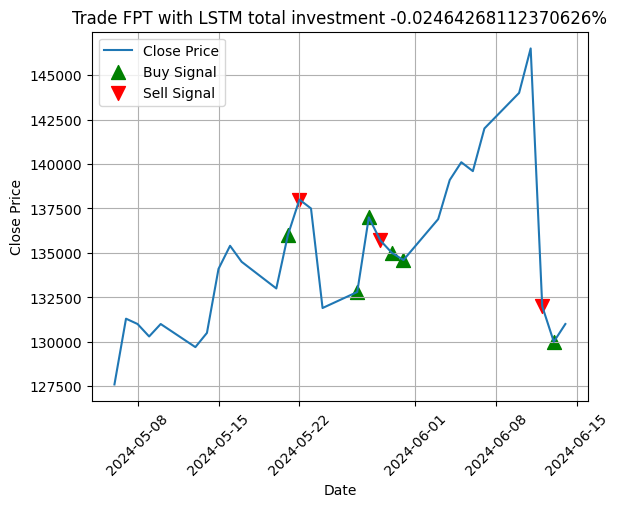

In [369]:

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} with LSTM total investment {last_total_investment}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

With LSTM

In [370]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = np.max(parameters[0]) * 3
minmax = pickle.load(open(f"checkpoint/{symbol}prediction_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}prediction_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [371]:
agent2 = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size= 10)

In [372]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent2.trade(value, date = date)
    trade_results.append(result)

[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1.85110354e-106 0.00000000e+000 1.00000000e+000]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]


In [373]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [374]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']

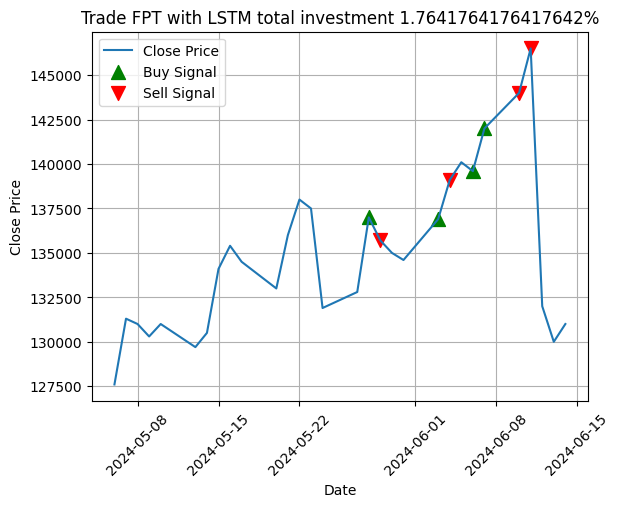

In [375]:
# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} with LSTM total investment {last_total_investment}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

DCA without LSTM

In [376]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = np.max(parameters[0]) * 5
minmax = pickle.load(open(f"checkpoint/{symbol}_DCAscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_DCAmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [377]:
agent3 = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size= 10)

In [378]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent3.trade(value, date = date)
    trade_results.append(result)

[0. 0. 1.]
[1.7452732e-68 0.0000000e+00 1.0000000e+00]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[9.10209899e-210 1.00000000e+000 0.00000000e+000]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]


In [379]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [380]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']

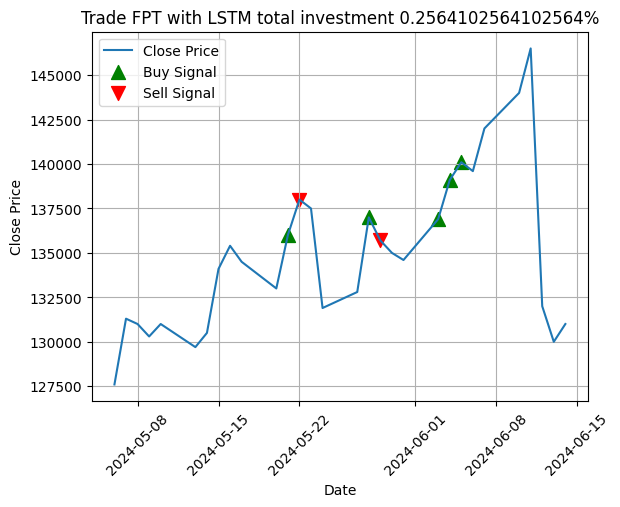

In [381]:
# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} with LSTM total investment {last_total_investment}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

DCA with LSTM

In [389]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = np.max(parameters[0]) * 5
minmax = pickle.load(open(f"checkpoint/{symbol}Prediction_DCAscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}Prediction_DCAmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [391]:
agent4 = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size= 10)

In [392]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent4.trade(value, date = date)
    trade_results.append(result)

[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]


In [393]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [394]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']

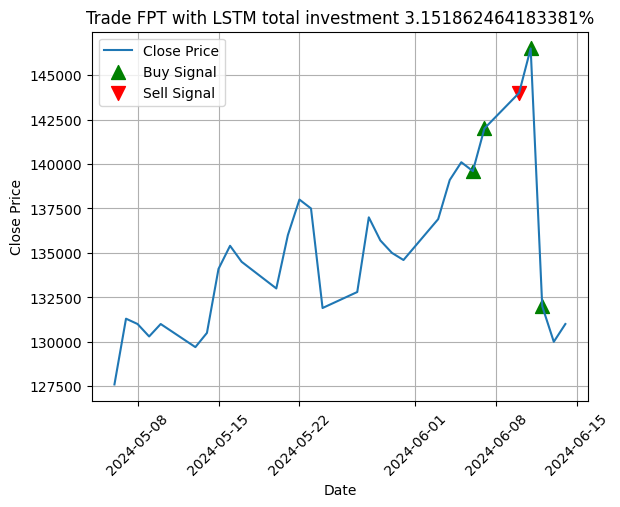

In [395]:
# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} with LSTM total investment {last_total_investment}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [388]:
result

,status,action,close,balance,timestamp,date,investment,total_investment,gain,total
0,data not enough to trade,0,127600.0,732500.0,2024-06-15 20:06:01.805149,2024-05-06,NaN,NaN,NaN,NaN
1,data not enough to trade,0,131300.0,732500.0,2024-06-15 20:06:01.805294,2024-05-07,NaN,NaN,NaN,NaN
2,data not enough to trade,0,131000.0,732500.0,2024-06-15 20:06:01.805294,2024-05-08,NaN,NaN,NaN,NaN
3,data not enough to trade,0,130300.0,732500.0,2024-06-15 20:06:01.805294,2024-05-09,NaN,NaN,NaN,NaN
4,data not enough to trade,0,131000.0,732500.0,2024-06-15 20:06:01.806292,2024-05-10,NaN,NaN,NaN,NaN
5,data not enough to trade,0,129700.0,732500.0,2024-06-15 20:06:01.806292,2024-05-13,NaN,NaN,NaN,NaN
6,data not enough to trade,0,130500.0,732500.0,2024-06-15 20:06:01.806292,2024-05-14,NaN,NaN,NaN,NaN
7,data not enough to trade,0,134100.0,732500.0,2024-06-15 20:06:01.807288,2024-05-15,NaN,NaN,NaN,NaN
8,data not enough to trade,0,135400.0,732500.0,2024-06-15 20:06:01.807288,2024-05-16,NaN,NaN,NaN,NaN
9,do nothing,0,134500.0,732500.0,2024-06-15 20:06:01.810781,2024-05-17,NaN,NaN,NaN,NaN
